<a href="https://colab.research.google.com/github/sol-sun/Generative_Deep_Learning_2nd_Pytorch/blob/main/05_autoregressive/pixelcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👾 PixelCNNのスクラッチ実装

本ノートブックでは，ファッションMNISTデータセットを用いたPixelCNNのスクラッチ実装を行う．

In [1]:
!pip install datasets | tail -n 1
!pip install japanize_matplotlib | tail -n 1
!pip install kagglehub | tail -n 1
!pip install torchinfo | tail -n 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import os
import re
import string
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
from datasets import Dataset as HFDataset
import torchvision
import torch
import torchinfo
import random
import json
import pandas as pd
import kagglehub
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, PretrainedConfig, PreTrainedModel, pipeline
from transformers.models.auto.modeling_auto import MODEL_FOR_CAUSAL_LM_MAPPING_NAMES
from transformers.modeling_outputs import CausalLMOutput

import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121
0.20.1+cu121


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)  # ディレクトリを作成
    model.eval()
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

def save_metrics(metrics_per_epoch, filename):
    # ディレクトリが存在しない場合は作成
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # ファイルにメトリクスを保存
    with open(filename, "w") as f:
        json.dump(metrics_per_epoch, f, indent=2)

# シード値を設定
set_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


## 0. パラメータ

In [4]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 128
N_FILTERS = 256
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 50

## 1. データの準備

In [5]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        torchvision.transforms.ToTensor(),
    ])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

CLASSES = np.array([
    "Tシャツ／トップス",
    "ズボン",
    "プルオーバー",  # 頭から被って着る服
    "ドレス",
    "コート",
    "サンダル",
    "シャツ",
    "スニーカー",
    "バッグ",
    "アンクルブーツ",  # かかとが隠れる丈のブーツ
])

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 313kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(16, 16), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.0431, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0235,
          0.2588, 0.4039, 0.2000, 0.0549, 0.0039, 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0863,
          0.6039, 0.7451, 0.5569, 0.4314, 0.2353, 0.1529, 0.2588, 0.1451],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.3098,
          0.8039, 0.8706, 0.8039, 0.6863, 0.5843, 0.5059, 0.5725, 0.3961],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4510,
          0.8588, 0.8667, 0.8588, 0.8588, 0.8392, 0.8000, 0.8510, 0.3686],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0235, 0.5373,
          0.8588, 0.8275, 0.7529

(1, 16, 16)


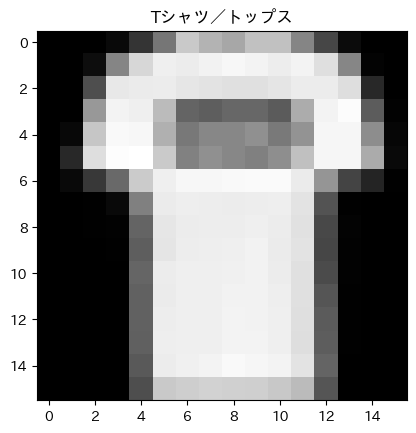

In [6]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[1][0].permute(1,2,0), cmap="gray")
plt.title(CLASSES[trainset[1][1]])
plt.show()

## 2. PixelCNNの実装(Channel=1)

In [7]:
class MaskedConv2D(nn.Module):
    def __init__(self, *args, mask_type, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.mask_type = mask_type
        # 最適化しないパラメータ
        self.register_buffer("mask", torch.zeros_like(self.conv.weight))
        in_channels, out_channels, kh, kw = self.conv.weight.shape
        self.mask[:, :, :kh//2, :] = 1.0
        self.mask[:, :, kh//2, :kw//2] = 1.0

        if self.mask_type == 'B':
        # type Bの場合，中央のカーネルも計算に含める
            self.mask[:, :, kh//2, kw//2] = 1.0

    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=filters, out_channels = filters//2, kernel_size=(1, 1), padding=0,
                               )
        self.pixel_conv = MaskedConv2D(in_channels=filters//2, out_channels = filters//2,
        mask_type="B", kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.batch = nn.BatchNorm2d(filters//2)
        self.conv2 = nn.Conv2d(in_channels=filters//2, out_channels = filters, kernel_size=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.relu(self.batch(self.pixel_conv(y)))
        y = self.conv2(y)
        return self.relu(x + y)


class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.masked_conv1 = MaskedConv2D(mask_type="A", in_channels=1, out_channels=N_FILTERS, kernel_size=(7, 7),
                                         stride=1, padding=3, bias=False)
        self.batch = nn.BatchNorm2d(N_FILTERS)
        self.residual_block = nn.Sequential(*[ResidualBlock(filters=N_FILTERS) for _ in range(RESIDUAL_BLOCKS)])
        self.relu = nn.ReLU()
        self.masked_conv = nn.ModuleList()
        for _ in range(2):
            self.masked_conv.append(MaskedConv2D(in_channels=N_FILTERS,
                                                 out_channels=N_FILTERS, kernel_size=(3, 3), stride=1, padding=1,
                                                 mask_type="B", bias=False))
            self.masked_conv.append(nn.BatchNorm2d(N_FILTERS))
            self.masked_conv.append(nn.ReLU())

        self.conv2 = nn.Conv2d(in_channels=N_FILTERS, out_channels=PIXEL_LEVELS, kernel_size=(1, 1), stride=1,
                               padding=0)

    def forward(self, x):
        x = self.relu(self.batch(self.masked_conv1(x)))
        x = self.residual_block(x)

        for block in self.masked_conv:
            x = block(x)

        x = self.conv2(x)
        return x

In [8]:
class MaskedConv2D(nn.Module):
    def __init__(self, *args, mask_type, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.mask_type = mask_type
        # 最適化しないパラメータ
        self.register_buffer("mask", torch.zeros_like(self.conv.weight))
        in_channels, out_channels, kh, kw = self.conv.weight.shape
        self.mask[:, :, :kh//2, :] = 1.0
        self.mask[:, :, kh//2, :kw//2] = 1.0

        if self.mask_type == 'B':
        # type Bの場合，中央のカーネルも計算に含める
            self.mask[:, :, kh//2, kw//2] = 1.0

    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=filters, out_channels = filters//2, kernel_size=(1, 1), padding=0,
                               )
        self.pixel_conv = MaskedConv2D(in_channels=filters//2, out_channels = filters//2,
        mask_type="B", kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.batch = nn.BatchNorm2d(filters//2)
        self.conv2 = nn.Conv2d(in_channels=filters//2, out_channels = filters, kernel_size=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.relu(self.batch(self.pixel_conv(y)))
        y = self.relu(self.conv2(y))
        return x + y

In [10]:
class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.masked_conv1 = MaskedConv2D(mask_type="A", in_channels=1, out_channels=N_FILTERS, kernel_size=(7, 7),
                                         stride=1, padding=3, bias=False)
        self.batch = nn.BatchNorm2d(N_FILTERS)
        self.residual_block = nn.Sequential(*[ResidualBlock(filters=N_FILTERS) for _ in range(RESIDUAL_BLOCKS)])
        self.relu = nn.ReLU()
        self.masked_conv = nn.ModuleList()
        for _ in range(2):
            self.masked_conv.append(MaskedConv2D(in_channels=N_FILTERS,
                                                 out_channels=N_FILTERS, kernel_size=(1, 1), stride=1, padding=0,
                                                 mask_type="B", bias=False))
            self.masked_conv.append(nn.BatchNorm2d(N_FILTERS))
            self.masked_conv.append(nn.ReLU())

        self.conv2 = nn.Conv2d(in_channels=N_FILTERS, out_channels=PIXEL_LEVELS, kernel_size=(1, 1), stride=1,
                               padding=0)

    def forward(self, x):
        x = self.relu(self.batch(self.masked_conv1(x)))
        x = self.residual_block(x)

        for block in self.masked_conv:
            x = block(x)

        x = self.conv2(x)
        return x

In [11]:
model = PixelCNN()
torchinfo.summary(model.eval(), input_size=(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
PixelCNN                                 [1, 128, 16, 16]          --
├─MaskedConv2D: 1-1                      [1, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 256, 16, 16]          12,544
├─BatchNorm2d: 1-2                       [1, 256, 16, 16]          512
├─ReLU: 1-3                              [1, 256, 16, 16]          --
├─Sequential: 1-4                        [1, 256, 16, 16]          --
│    └─ResidualBlock: 2-2                [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          32,896
│    │    └─ReLU: 3-2                    [1, 128, 16, 16]          --
│    │    └─MaskedConv2D: 3-3            [1, 128, 16, 16]          147,456
│    │    └─BatchNorm2d: 3-4             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-5                    [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-6                  [1, 256, 16, 16]          33,

## 3. PixelCNNモデルを学習

In [12]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### 学習する場合は以下（GPU推奨）

In [13]:
# model = model.to(device)
# model.train()
# metrics_per_epoch = {
#     "loss": [],
# }
# for epoch in range(EPOCHS):
#     epoch_metrics = {metric: 0 for metric in metrics_per_epoch}
#     batch_count = 0
#     for i, data in enumerate(trainloader, 0):
#         images, _ = data
#         images = images.to(device)
#         # 0-1を0-PIXEL_LEVELS-1(整数)にスケーリングする
#         target = torch.clamp(torch.round(images[:, 0, :, :] * PIXEL_LEVELS).long(), min=0, max=PIXEL_LEVELS-1)

#         optimizer.zero_grad()

#         output = model(images)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()

#         for key in epoch_metrics:
#             epoch_metrics[key] += loss.item()
#         batch_count += 1
#     for key in epoch_metrics:
#         epoch_metrics[key] /= batch_count
#         metrics_per_epoch[key].append(epoch_metrics[key])

#     # epoch終了時点でのlossの平均値
#     print("Epoch {}:".format(epoch + 1), epoch_metrics)

In [14]:
  # # modelを保存
  # save_path = f"./models/scrach_pixelcnn_model_epoch_{EPOCHS}.pth"

  # save_model(model, save_path)

  # # metricsを保存
  # metrics_save_path = f"./metrics/scrach_pixelcnn_metrics.json"
  # save_metrics(metrics_per_epoch=metrics_per_epoch, filename=metrics_save_path)

### 学習済みモデルをロードする場合は以下

In [15]:
import urllib.request

# モデルのURL
model_url = "https://github.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/raw/main/05_autoregressive/models/scrach_pixelcnn_model_epoch_50.pth"
local_model_path = "scrach_pixelcnn_model_epoch_50.pth"

# モデルをダウンロード
urllib.request.urlretrieve(model_url, local_model_path)

# モデルをデバイスに移動して読み込み
model = load_model(model, local_model_path, device)

Model loaded from scrach_pixelcnn_model_epoch_50.pth


## 4. PixelCNNを使って画像を生成する

In [16]:
class ImageGenerator():
    def __init__(self, pixelcnn_model, num_img):
        self.num_img = num_img
        self.model = pixelcnn_model
        self.model.eval()
        self.softmax = nn.Softmax(dim=-1)

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs /= torch.sum(probs, dim=1, keepdim=True)
        probs = probs.to(device)
        return torch.multinomial(probs, num_samples=1, replacement=True).float()

    def generate(self, temperature):
        generated_images = torch.zeros((self.num_img,) + (BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE)[1:])
        generated_images = generated_images.to(device)
        batch, channels, rows, cols = generated_images.shape

        for channel in range(channels):
            for row in range(rows):
                for col in range(cols):
                    probs = self.model(generated_images).cpu().detach()[:, :, row, col]
                    probs = self.softmax(probs).cpu().detach()

                    generated_images[:, [channel], row, col] = (
                                self.sample_from(probs, temperature) / (PIXEL_LEVELS - 1))

        return generated_images

image_generator = ImageGenerator(model, num_img=10)
generated_images = image_generator.generate(temperature=1.0)

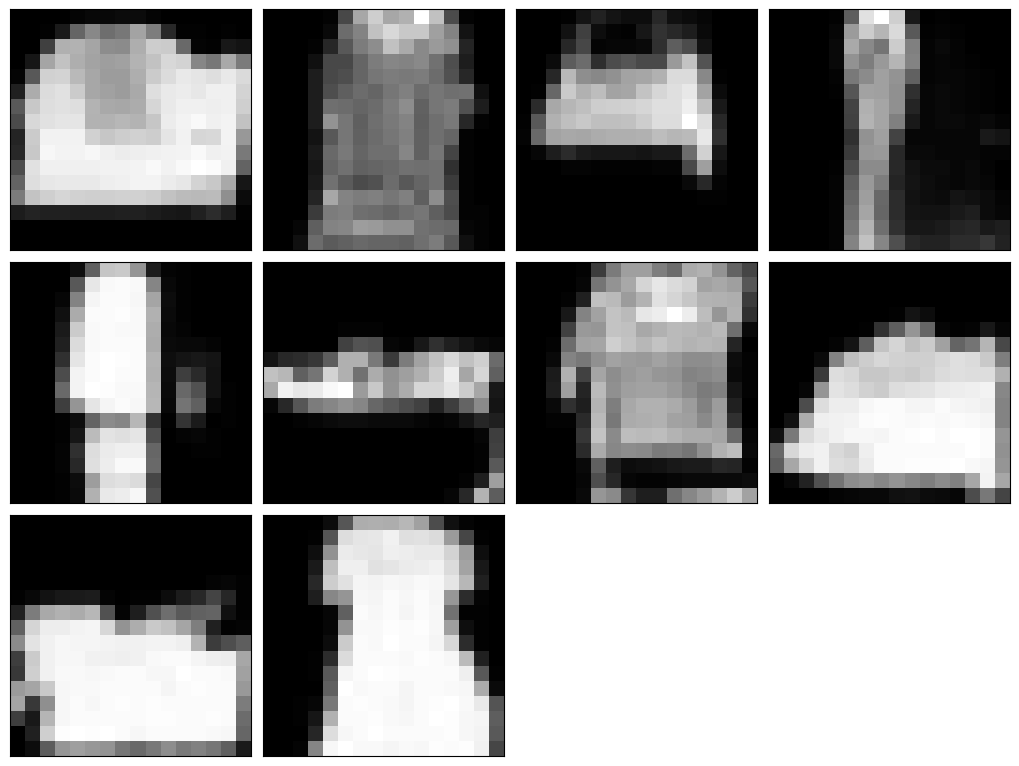

In [17]:
# 画像を図示する
def plot_images(generated_images):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(generated_images.size()[0]):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(generated_images[i].permute(1,2,0).cpu().detach().numpy(), cmap="gray")
    plt.show()

plot_images(generated_images)